In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# import dataset from local
df = pd.read_csv(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\cleaned_data\Fleet Dataset.csv")

In [6]:
df.shape

(1583, 11)

In [7]:
# df.info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Parent Airline        1583 non-null   object 
 1   Airline               1583 non-null   object 
 2   Aircraft Type         1583 non-null   object 
 3   Current               859 non-null    float64
 4   Future                188 non-null    float64
 5   Historic              1113 non-null   float64
 6   Total                 1484 non-null   float64
 7   Orders                348 non-null    float64
 8   Unit Cost             1548 non-null   object 
 9   Total Cost (Current)  1556 non-null   object 
 10  Average Age           820 non-null    float64
dtypes: float64(6), object(5)
memory usage: 136.2+ KB


In [8]:
# Check null values
df.isna().sum()

Parent Airline             0
Airline                    0
Aircraft Type              0
Current                  724
Future                  1395
Historic                 470
Total                     99
Orders                  1235
Unit Cost                 35
Total Cost (Current)      27
Average Age              763
dtype: int64

In [9]:
# check stats
df.describe()

,Current,Future,Historic,Total,Orders,Average Age
count,859.000000,188.000000,1113.000000,1484.000000,348.000000,820.000000
mean,24.033760,3.382979,14.513028,24.955526,26.419540,10.115000
std,41.091234,4.656331,23.763373,46.651526,43.024179,6.859362
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000
25%,5.000000,1.000000,3.000000,4.000000,5.000000,5.000000
50%,12.000000,2.000000,7.000000,11.000000,13.500000,8.900000
75%,26.500000,4.000000,16.000000,27.000000,28.250000,14.500000
max,718.000000,38.000000,325.000000,952.000000,400.000000,39.000000


In [10]:
# check first 5 rows
df.head()
# issue: too many null values and '$' in total Cost column

,Parent Airline,Airline,Aircraft Type,Current,Future,Historic,Total,Orders,Unit Cost,Total Cost (Current),Average Age
0,Aegean Airlines,Aegean Airlines,Airbus A319,1.0,NaN,3.0,4.0,NaN,$90,$90,11.6
1,Aegean Airlines,Olympic Air,Airbus A319,NaN,NaN,8.0,8.0,NaN,$90,$0,NaN
2,Aegean Airlines,Aegean Airlines,Airbus A320,38.0,NaN,3.0,41.0,NaN,$98,"$3,724",7.5
3,Aegean Airlines,Olympic Air,Airbus A320,NaN,NaN,9.0,9.0,NaN,$98,$0,NaN
4,Aegean Airlines,Aegean Airlines,Airbus A321,8.0,NaN,NaN,8.0,NaN,$115,$919,10.3


In [11]:
# convert currency column

currency_columns = ['Unit Cost', 'Total Cost (Current)']

# remove '$' symbol and ','

for col in currency_columns:
    df[col] = df[col].replace({r'\$': '', ',': ''}, regex=True).astype(float)

df[currency_columns].dtypes, df[currency_columns].head()

(Unit Cost               float64
 Total Cost (Current)    float64
 dtype: object,
    Unit Cost  Total Cost (Current)
 0       90.0                  90.0
 1       90.0                   0.0
 2       98.0                3724.0
 3       98.0                   0.0
 4      115.0                 919.0)

In [12]:
# check the first 5 rows of the df
df.head()

,Parent Airline,Airline,Aircraft Type,Current,Future,Historic,Total,Orders,Unit Cost,Total Cost (Current),Average Age
0,Aegean Airlines,Aegean Airlines,Airbus A319,1.0,NaN,3.0,4.0,NaN,90.0,90.0,11.6
1,Aegean Airlines,Olympic Air,Airbus A319,NaN,NaN,8.0,8.0,NaN,90.0,0.0,NaN
2,Aegean Airlines,Aegean Airlines,Airbus A320,38.0,NaN,3.0,41.0,NaN,98.0,3724.0,7.5
3,Aegean Airlines,Olympic Air,Airbus A320,NaN,NaN,9.0,9.0,NaN,98.0,0.0,NaN
4,Aegean Airlines,Aegean Airlines,Airbus A321,8.0,NaN,NaN,8.0,NaN,115.0,919.0,10.3


In [13]:
# replacing null values with median instead of mean to avoid outlier
df.fillna(df.median(numeric_only=True), inplace=True)

In [14]:
# check unique values limited to 5 rows
df.nunique()

Parent Airline          117
Airline                 280
Aircraft Type           101
Current                 113
Future                   18
Historic                 93
Total                   141
Orders                   84
Unit Cost                55
Total Cost (Current)    488
Average Age             242
dtype: int64

In [15]:
# Most common 5 types (Aircrafts)
df['Aircraft Type'].value_counts().head(5)

Aircraft Type
Boeing 737     147
Airbus A320    135
Airbus A330     86
Boeing 767      83
Airbus A321     79
Name: count, dtype: int64

In [16]:
# Average cost for each aircraft type
avg_cost = df.groupby('Aircraft Type')['Unit Cost'].mean().sort_values(ascending=False)
avg_cost.head()

Aircraft Type
Airbus A380        433.00000
Boeing 777-300     320.00000
Airbus A350        312.00000
Boeing 747         308.46875
Airbus A350-900    308.00000
Name: Unit Cost, dtype: float64

In [17]:
# total orders or boeing and airbus
airbus_orders = df[df['Aircraft Type'].str.contains('Airbus', case=False, na=False)]['Orders'].sum()
boeing_orders = df[df['Aircraft Type'].str.contains('boeing', case=False, na=False)]['Orders'].sum()

airbus_orders, boeing_orders

(9687.0, 8269.5)

In [20]:
conditions = [df['Aircraft Type'].str.contains('Airbus', case=False, na=False),
              df['Aircraft Type'].str.contains('Boeing', case=False, na=False)]

values = ['Airbus', 'Boeing']

df['Manufacturer'] = np.select(conditions, values, default='Other')
df['Manufacturer'].value_counts()

Manufacturer
Other     567
Airbus    543
Boeing    473
Name: count, dtype: int64

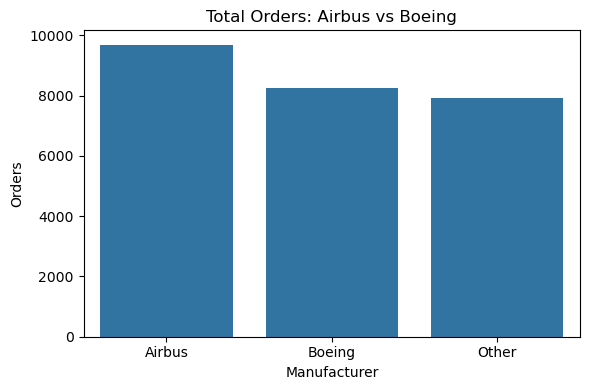

In [24]:
# Total orders for Airbus and Boeing 
total_orders = df.groupby('Manufacturer')['Orders'].sum()

# Chart: Total Orders by Manufacturer
plt.figure(figsize=(6,4))
sns.barplot(x=total_orders.index, y=total_orders.values)
plt.title('Total Orders: Airbus vs Boeing')
plt.ylabel('Orders')
plt.xlabel('Manufacturer')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\total_orders_manufacturer.png", dpi=300)
plt.show()

In [25]:
# Filter for Airbus and Boeing
airbus_df = df[df['Aircraft Type'].str.contains('Airbus', case=False, na=False)]
boeing_df = df[df['Aircraft Type'].str.contains('Boeing', case=False, na=False)]

# Group by model and sum orders
order_model_airbus = airbus_df.groupby('Aircraft Type')['Orders'].sum()
order_model_boeing = boeing_df.groupby('Aircraft Type')['Orders'].sum()

# Most and least ordered Airbus models
airbus_successful_model = order_model_airbus.idxmax(), order_model_airbus.max()
airbus_least_successful_model = order_model_airbus.idxmin(), order_model_airbus.min()

# Most and least ordered Boeing models
boeing_successful_model = order_model_boeing.idxmax(), order_model_boeing.max()
boeing_least_successful_model = order_model_boeing.idxmin(), order_model_boeing.min()

# Output
boeing_successful_model, boeing_least_successful_model, airbus_successful_model, airbus_least_successful_model

(('Boeing 737', 3663.5),
 ('Boeing 777-300', 4.0),
 ('Airbus A320', 3613.0),
 ('Airbus A320-200', 13.5))

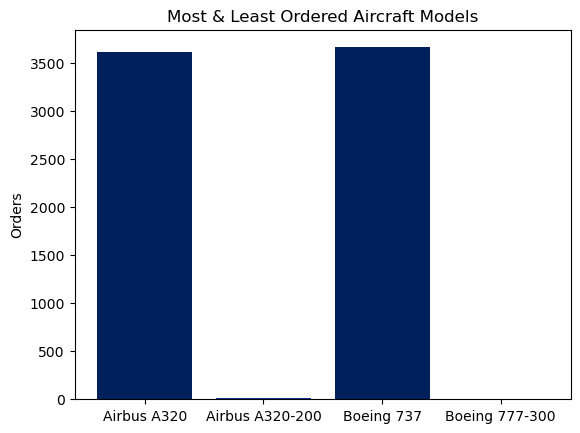

In [27]:
# Basic data
models = [
    airbus_successful_model[0],
    airbus_least_successful_model[0],
    boeing_successful_model[0],
    boeing_least_successful_model[0]
]

orders = [
    airbus_successful_model[1],
    airbus_least_successful_model[1],
    boeing_successful_model[1],
    boeing_least_successful_model[1]
]

# bar plot
plt.bar(models, orders, color=['#00205b', '#0033a1'])
plt.title('Most & Least Ordered Aircraft Models')
plt.ylabel('Orders')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\most_&_least_models.png", dpi=300)
plt.show()

In [28]:
# Group all aircraft models and find most total orders
most_ordered_model = df.groupby('Aircraft Type')['Orders'].sum().idxmax()
most_orders = df.groupby('Aircraft Type')['Orders'].sum().max()

most_ordered_model, most_orders

('Boeing 737', 3663.5)

In [29]:
# Group all aircraft models and find most total orders
least_ordered_model = df.groupby('Aircraft Type')['Orders'].sum().idxmin()
least_orders = df.groupby('Aircraft Type')['Orders'].sum().min()

least_ordered_model, least_orders

('Boeing 777-300', 4.0)

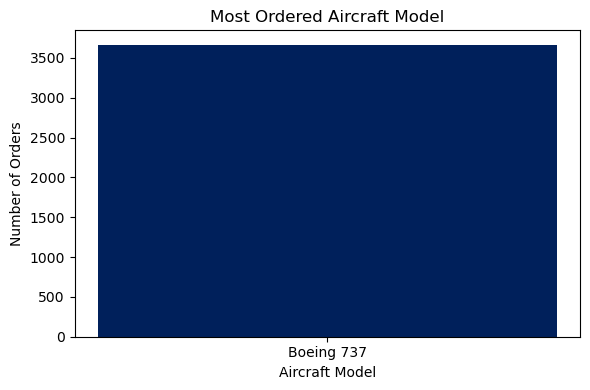

In [31]:
# most ordered model and its order count
model_orders = df.groupby('Aircraft Type')['Orders'].sum()
most_ordered_model = model_orders.idxmax()
most_orders = model_orders.max()

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(most_ordered_model, most_orders, color=['#00205b', '#0033a1'])
plt.title('Most Ordered Aircraft Model')
plt.ylabel('Number of Orders')
plt.xlabel('Aircraft Model')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\most_ordered_aircraft_model.png", dpi=300)
plt.show()

In [33]:
# compare future orders of airbus and boeing
future_orders = {
    'Airbus': airbus_df['Future'].sum(min_count=1),
    'Boeing': boeing_df['Future'].sum(min_count=1)
}

future_orders

{'Airbus': 1195.0, 'Boeing': 1054.0}

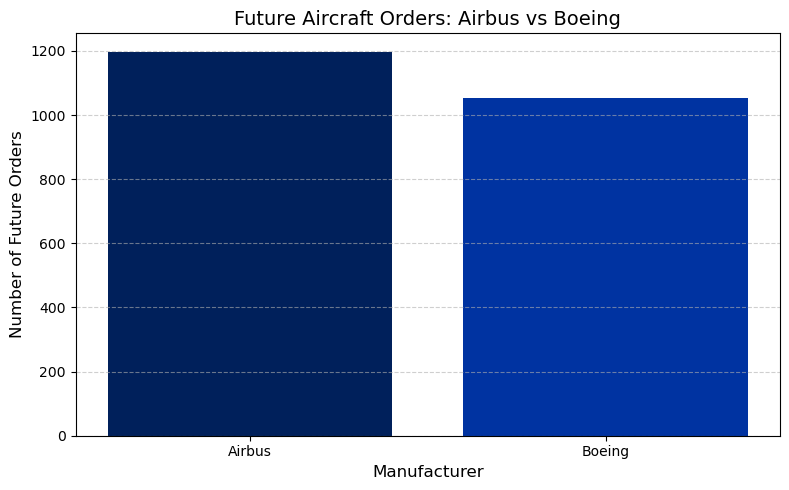

In [35]:
# Data: Future aircraft orders
manufacturers = list(future_orders.keys())
orders = list(future_orders.values())

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(manufacturers, orders, color=['#00205b', '#0033a1'])
plt.title("Future Aircraft Orders: Airbus vs Boeing", fontsize=14)
plt.xlabel("Manufacturer", fontsize=12)
plt.ylabel("Number of Future Orders", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_total_orders_manufacturer.png", dpi=300)
plt.show()

In [36]:
# airlines usages by airbus & boeing
# Group by airline 
top_airbus_airline = airbus_df.groupby('Airline')['Current'].sum().idxmax()
top_boeing_airline = boeing_df.groupby('Airline')['Current'].sum().idxmax()

# get counts of aircraft by airline
airbus_count = airbus_df.groupby('Airline')["Current"].sum().max()
boeing_count = boeing_df.groupby('Airline')["Current"].sum().max()

airbus_count, boeing_count

(421.0, 718.0)

In [37]:
# airlines usages by airbus & boeing
# Group by airline 
top_airbus_airline = airbus_df.groupby('Airline')['Current'].sum().idxmax()
top_boeing_airline = boeing_df.groupby('Airline')['Current'].sum().idxmax()

# get counts of aircraft by airline
airbus_count_min = airbus_df.groupby('Airline')["Current"].sum().min()
boeing_count_min = boeing_df.groupby('Airline')["Current"].sum().min()

airbus_count, boeing_count

(421.0, 718.0)

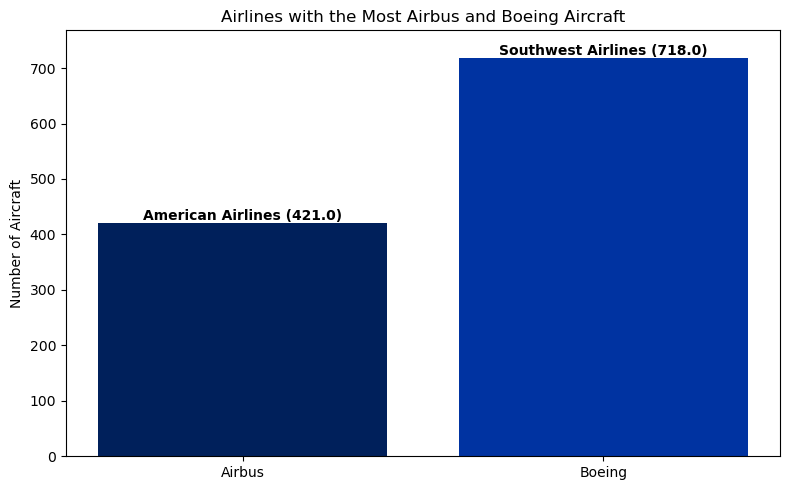

In [39]:
# Data: Airline names and their fleet counts
manufacturers = ['Airbus', 'Boeing']
fleet_counts = [airbus_count, boeing_count]
top_airlines = [top_airbus_airline, top_boeing_airline]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(manufacturers, fleet_counts, color=['#00205b', '#0033a1'])

# Add airline names and values on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f"{top_airlines[i]} ({fleet_counts[i]})", ha='center', fontsize=10, fontweight='bold')

plt.title("Airlines with the Most Airbus and Boeing Aircraft")
plt.ylabel("Number of Aircraft")
plt.ylim(0, max(fleet_counts) + 50)
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\airlines_with_most_aircraft.png", dpi=300)
plt.show()

In [40]:
def get_manufacturer(aircraft_type):
    if 'Airbus' in str(aircraft_type):
        return 'Airbus'
    elif 'Boeing' in str(aircraft_type):
        return 'Boeing'
    else:
        return 'Other'

# create separte column for manufacturer        
df['Manufacturer'] = df['Aircraft Type'].apply(get_manufacturer)

manufacturer_summary = df.groupby('Manufacturer')[['Future', 'Orders']].sum().reset_index()
manufacturer_summary

,Manufacturer,Future,Orders
0,Airbus,1195.0,9687.0
1,Boeing,1054.0,8269.5
2,Other,1177.0,7910.0


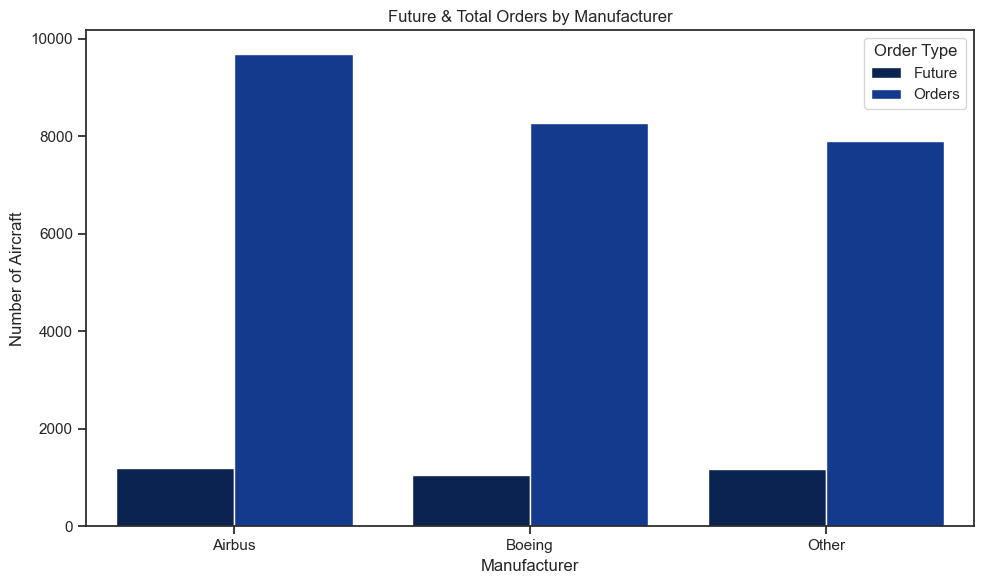

In [42]:
# Set style
sns.set(style="ticks")

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=manufacturer_summary.melt(id_vars='Manufacturer', 
                                                      value_vars=['Future', 'Orders']),
                      x='Manufacturer', y='value', hue='variable',
                      palette={'Future': '#00205b', 'Orders': '#0033a1'})

# Labels and titles
plt.title('Future & Total Orders by Manufacturer')
plt.ylabel('Number of Aircraft')
plt.xlabel('Manufacturer')
plt.legend(title='Order Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_and_total_orders_manufacturer.png", dpi=300)
plt.show()

In [44]:
# filter for only airbus vs boieng comparison 
df_filtered = df[df['Manufacturer'].isin(['Airbus', 'Boeing'])]

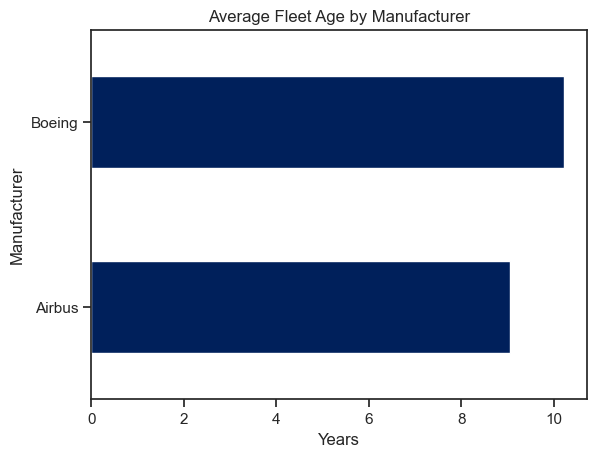

In [46]:
df_filtered.groupby('Manufacturer')['Average Age'].mean().plot(kind='barh', color='#00205b')
plt.title('Average Fleet Age by Manufacturer')
plt.xlabel('Years')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\avg_fleet_age.png", dpi=300)
plt.show()

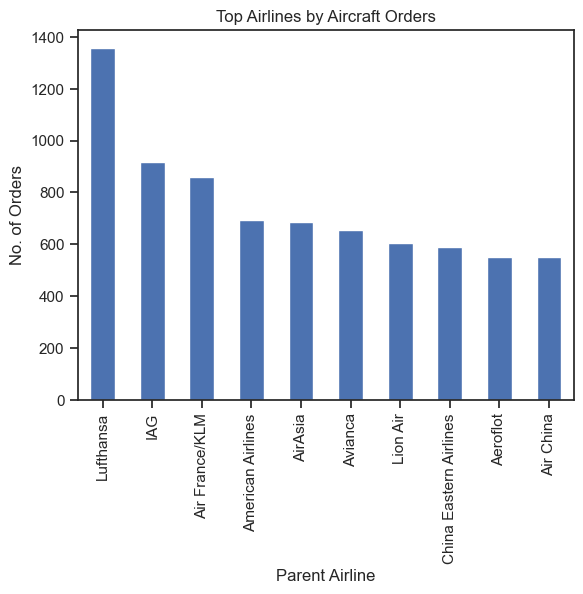

In [48]:
# Top airlines with most orders "desc"

df.groupby('Parent Airline')['Orders'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top Airlines by Aircraft Orders')
plt.ylabel('No. of Orders')
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airlines_orders.png", dpi=300)
plt.show()

In [49]:
# Filtering the Indian Airlines order
indian_airlines = ['Air India', 'IndiGo', 'SpiceJet', 'AirAsia India']
indian_airlines

['Air India', 'IndiGo', 'SpiceJet', 'AirAsia India']

In [50]:
# Grouping all airlines (India) Orders
df_india = df[df['Parent Airline'].isin(indian_airlines)]
df_india.groupby('Parent Airline')[['Historic', 'Future']].sum()

,Historic,Future
Parent Airline,,
Air India,138.0,42.0
IndiGo,23.0,12.0
SpiceJet,40.0,8.0


In [51]:
# comparing future orders of indian airlines
df_india_filtered = df_india[df_india['Manufacturer'].isin(['Airbus', 'Boeing'])]

future_orders = df_india_filtered.groupby(['Parent Airline', 'Manufacturer'])['Future'].sum().reset_index().head()
future_orders

,Parent Airline,Manufacturer,Future
0,Air India,Airbus,14.0
1,Air India,Boeing,20.0
2,IndiGo,Airbus,12.0
3,SpiceJet,Airbus,4.0
4,SpiceJet,Boeing,2.0


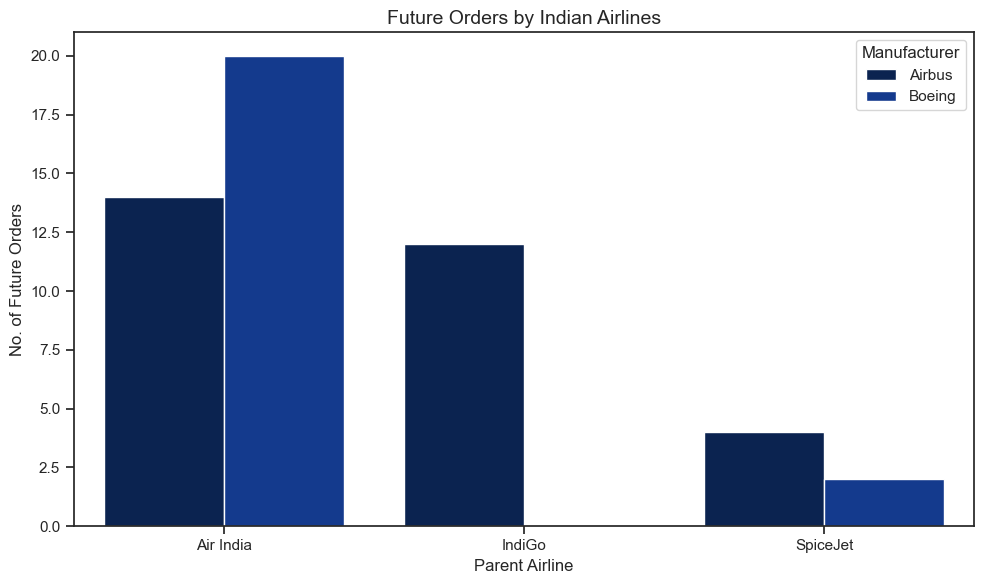

In [53]:
# Visualizing future order by indian airlines
plt.figure(figsize=(10,6))
sns.barplot(data=future_orders, x='Parent Airline', y='Future', hue='Manufacturer', palette= {'#00205b', '#0033a1'})

plt.title('Future Orders by Indian Airlines', fontsize=14)
plt.ylabel('No. of Future Orders')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\future_orders_by_indies_airlines.png", dpi=300)
plt.show()

In [54]:
# creating a new columns Total Orders
df['Total Orders'] = df['Historic'] + df['Current'] + df['Future']
boeing_df1 = df[df['Manufacturer'] == 'Boeing']
airbus_df1 = df[df['Manufacturer'] == 'Airbus']

In [55]:
# Total orders: Boeing
boeing_total_orders = boeing_df1.groupby(['Parent Airline', 'Aircraft Type'])['Total Orders'].sum().reset_index().sort_values(by='Total Orders', ascending=False).head()
boeing_total_orders

,Parent Airline,Aircraft Type,Total Orders
298,Southwest Airlines,Boeing 737,951.0
327,United Airlines,Boeing 737,618.0
26,Air China,Boeing 737,498.0
275,Ryanair,Boeing 737,476.0
37,Air France/KLM,Boeing 737,336.0


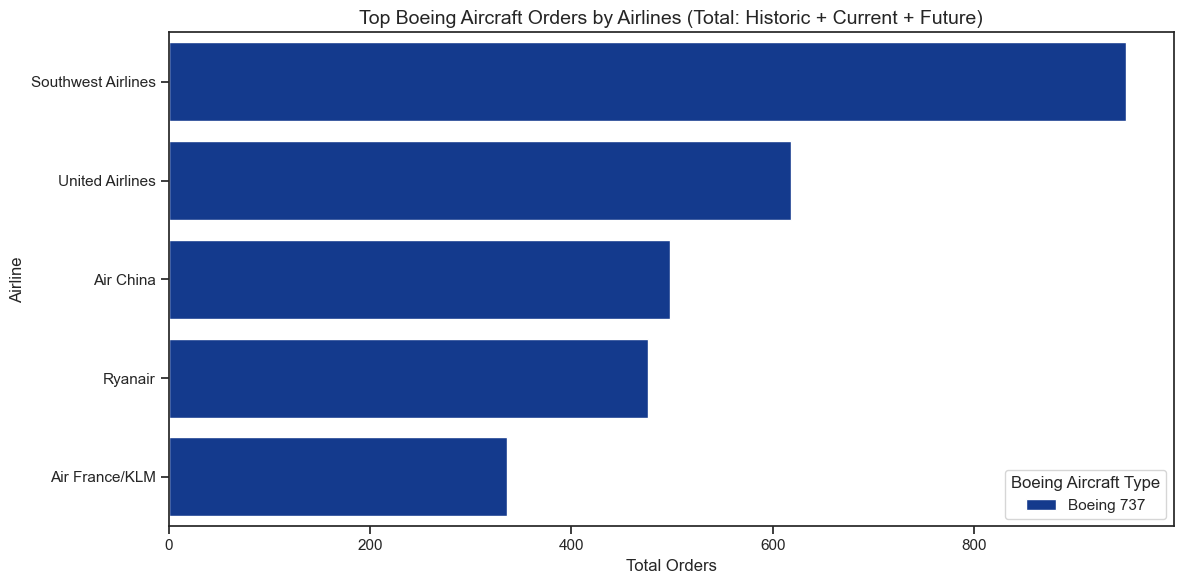

In [57]:
# Define Boeing blue color palette
boeing_palette = {
    '#0033a1'
}

plt.figure(figsize=(12, 6))

sns.barplot(
    data=boeing_total_orders,
    y='Parent Airline',
    x='Total Orders',
    hue='Aircraft Type',
    dodge=False,
    palette=boeing_palette  
)

plt.title('Top Boeing Aircraft Orders by Airlines (Total: Historic + Current + Future)', fontsize=14)
plt.xlabel('Total Orders')
plt.ylabel('Airline')
plt.legend(title='Boeing Aircraft Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_boeing_aircrafts_orders_by_airlines.png", dpi=300)
plt.show()

In [58]:
# Total Airbus orders
airbus_total_orders = airbus_df1.groupby(['Parent Airline', 'Aircraft Type'])['Total Orders'].sum().reset_index().sort_values(by='Total Orders', ascending=False).head()
airbus_total_orders

,Parent Airline,Aircraft Type,Total Orders
198,IAG,Airbus A320,363.0
71,AirAsia,Airbus A320,268.0
237,Lufthansa,Airbus A320,268.0
89,American Airlines,Airbus A321,216.0
398,easyJet,Airbus A319,209.0


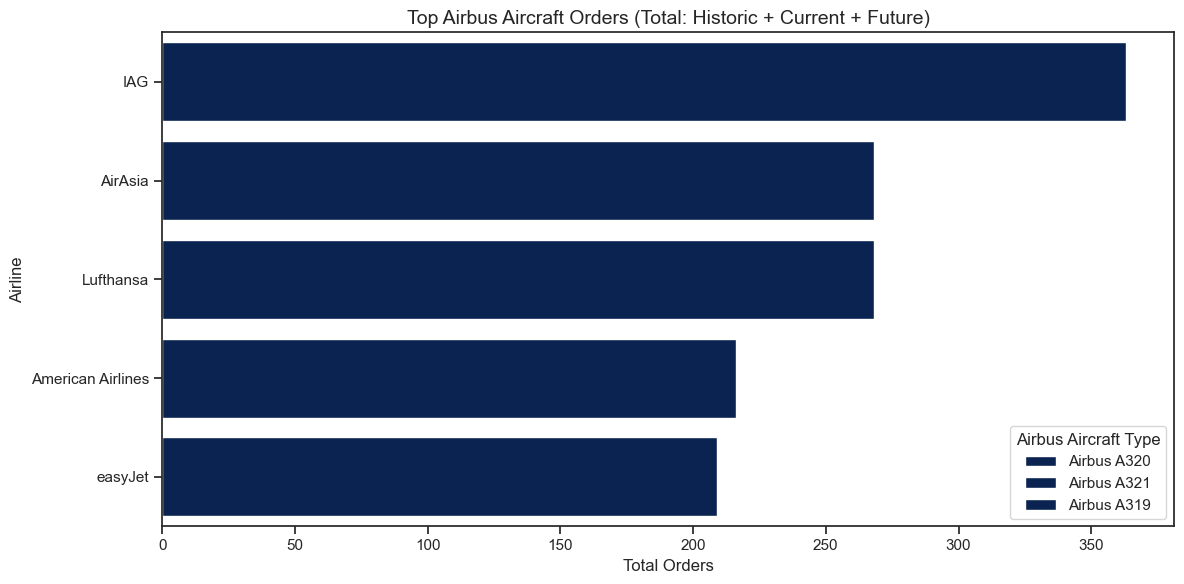

In [60]:
plt.figure(figsize=(12, 6))

# Airbus blue-inspired palette (feel free to tweak or use Airbus branding)
airbus_palette = {
    '#00205B'
}

# Plot horizontal bar chart
sns.barplot(
    data=airbus_total_orders,
    y='Parent Airline',
    x='Total Orders',
    hue='Aircraft Type',
    dodge=False,
    palette=airbus_palette  
)

plt.title('Top Airbus Aircraft Orders (Total: Historic + Current + Future)', fontsize=14)
plt.xlabel('Total Orders')
plt.ylabel('Airline')
plt.legend(title='Airbus Aircraft Type')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airbus_orders.png", dpi=300)
plt.show()

<Axes: xlabel='Aircraft Type'>

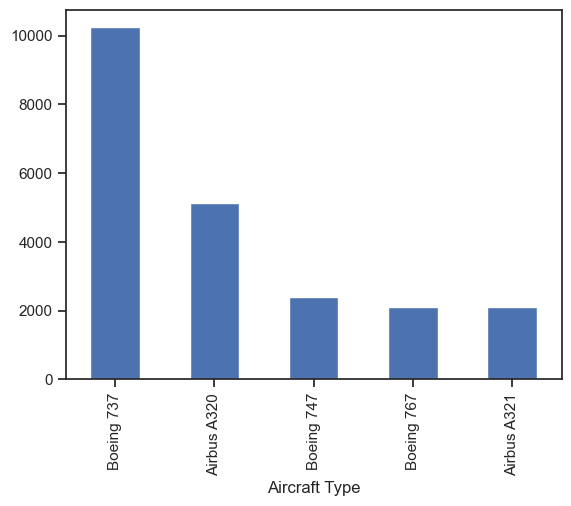

In [61]:
# total orders: aircraft models
df.groupby('Aircraft Type')['Total Orders'].sum().sort_values(ascending=False).head().plot(kind='bar')


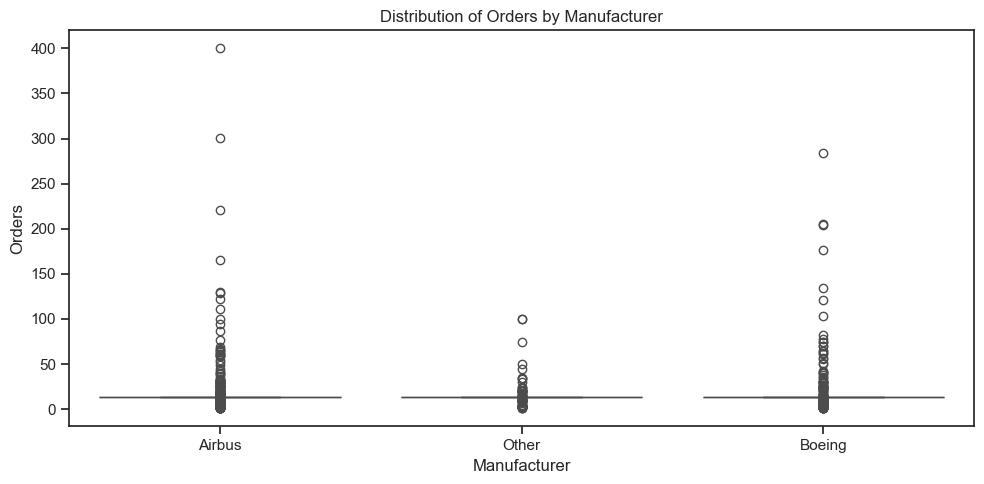

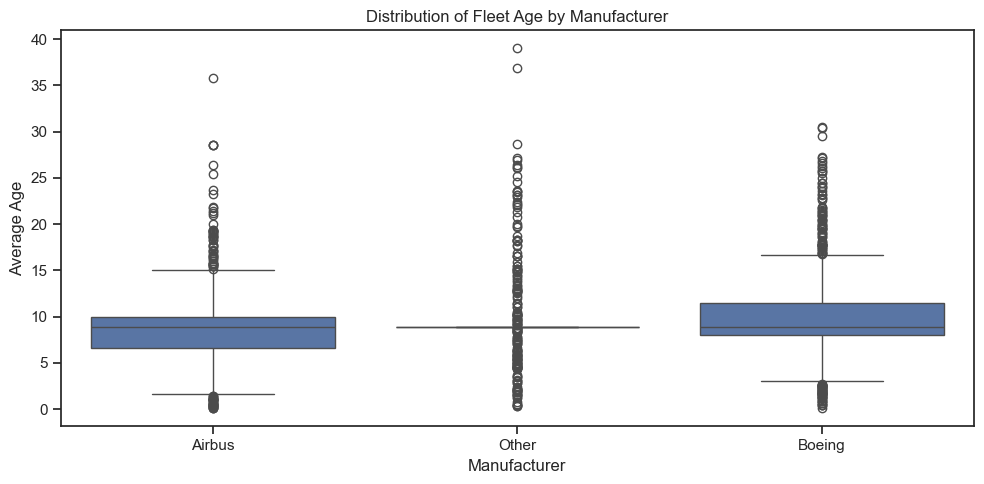

In [63]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Manufacturer', y='Orders')
plt.title('Distribution of Orders by Manufacturer')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Manufacturer', y='Average Age')
plt.title('Distribution of Fleet Age by Manufacturer')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\distribution_of_orders_by_manufacturer.png", dpi=300)
plt.show()

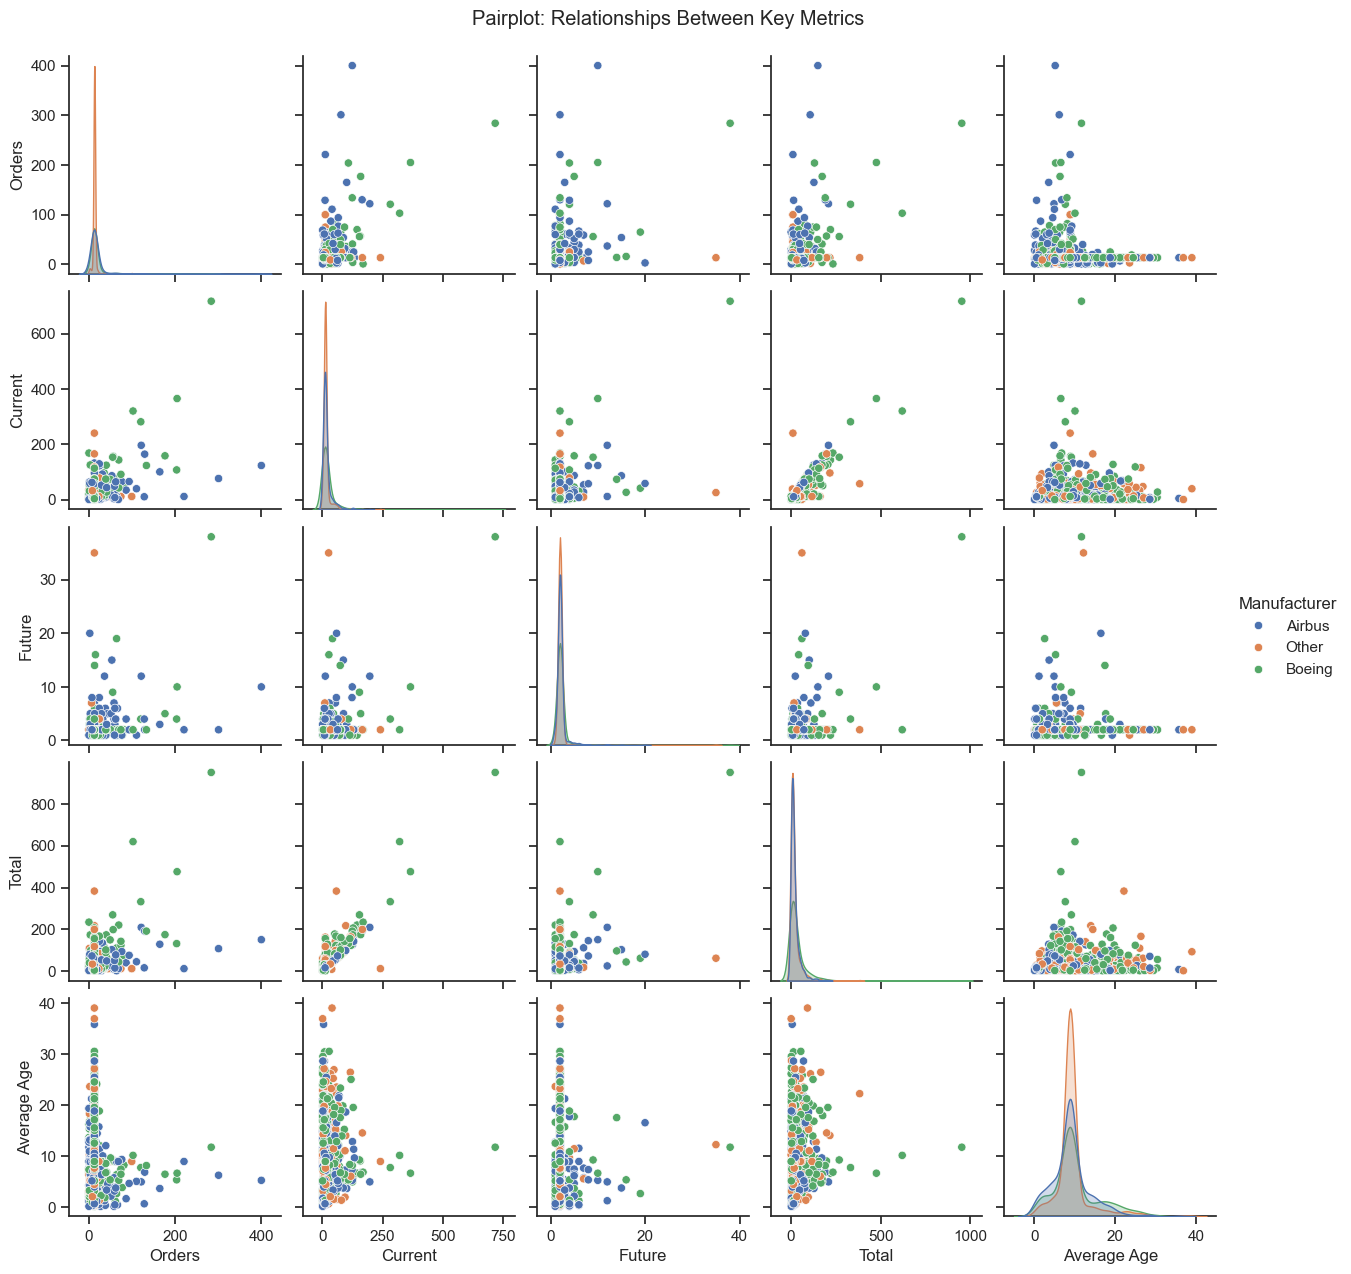

In [65]:
sns.pairplot(df[['Orders', 'Current', 'Future', 'Total', 'Average Age', 'Manufacturer']], hue='Manufacturer')
plt.suptitle('Pairplot: Relationships Between Key Metrics', y=1.02)
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\relationship_between_key_metrics.png", dpi=300)
plt.show()

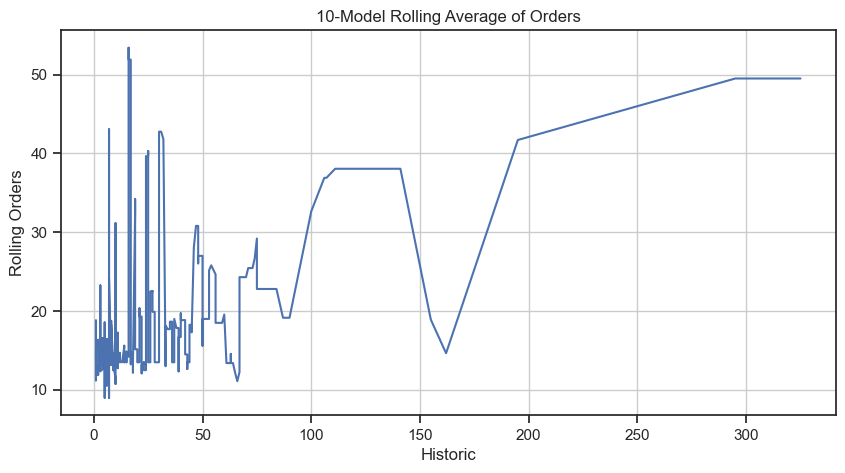

In [67]:
df_sorted = df.sort_values('Historic')

df_sorted['rolling_orders'] = df_sorted['Orders'].rolling(window=10).mean()

plt.figure(figsize=(10,5))
plt.plot(df_sorted['Historic'], df_sorted['rolling_orders'])
plt.title('10-Model Rolling Average of Orders')
plt.xlabel('Historic')
plt.ylabel('Rolling Orders')
plt.grid(True)
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\avg_orders.png", dpi=300)
plt.show()

In [71]:
df.columns

Index(['Parent Airline', 'Airline', 'Aircraft Type', 'Current', 'Future',
       'Historic', 'Total', 'Orders', 'Unit Cost', 'Total Cost (Current)',
       'Average Age', 'Manufacturer', 'Total Orders', 'Revenue Potential'],
      dtype='object')

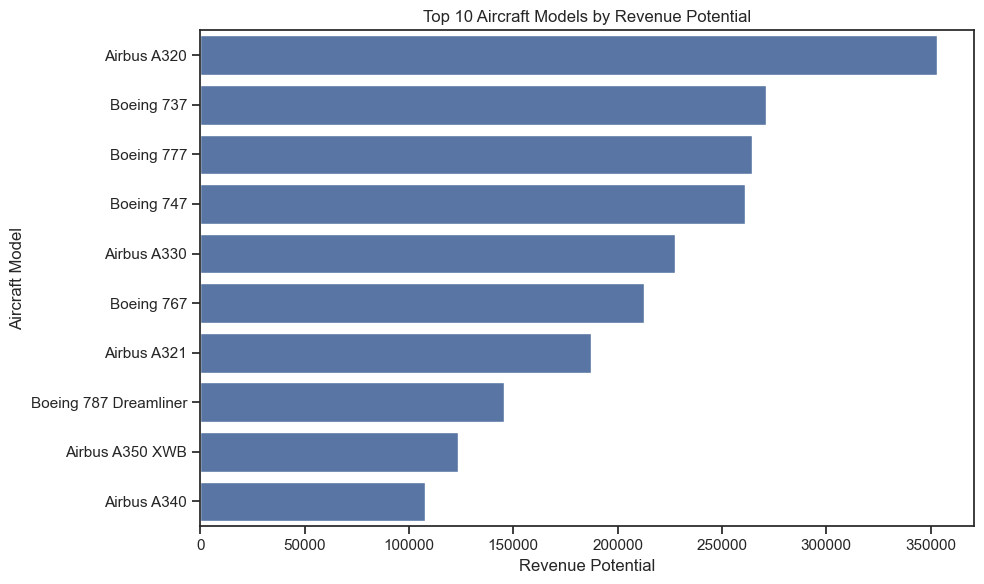

In [72]:
df['Revenue Potential'] = df['Orders'] * df['Unit Cost']

model_revenue = (
    df.groupby('Aircraft Type')['Revenue Potential']
      .sum()
      .rename('Revenue Potential')      # stays 1D
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x=model_revenue.head(10).values, 
    y=model_revenue.head(10).index
)
plt.title('Top 10 Aircraft Models by Revenue Potential')
plt.xlabel('Revenue Potential')
plt.ylabel('Aircraft Model')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_10_model_revenue.png", dpi=300)
plt.show()

In [73]:
# Profitability Ratio

df['Profitability Ratio'] = df['Revenue Potential'] / (df['Current'] + df['Future'] + 1)

In [74]:
top_profitability = (
    df.groupby('Aircraft Type')['Profitability Ratio'].mean()
      .sort_values(ascending=False)
      .head(10)
)

top_profitability

Aircraft Type
Airbus A350-900                        574.933333
Airbus A350 XWB                        563.863129
Boeing 747                             377.890721
Airbus A380                            355.382970
Boeing 787 Dreamliner                  335.154403
Airbus A350                            325.828571
Irkut MC-21                            273.333333
Boeing 787                             261.262821
Embraer E175-E2                        260.000000
Gulfstream Aerospace G-V Gulfstream    253.125000
Name: Profitability Ratio, dtype: float64

In [75]:
# Airlies Revenues 
airline_revenue = (
    df.groupby('Airline')['Revenue Potential']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

airline_revenue

Airline
Emirates                  88570.5
Qatar Airways             64827.0
Etihad Airways            63517.5
American Airlines         61422.5
Delta Airlines            59006.0
Lufthansa                 55099.5
Singapore Airlines        49518.5
AirAsia                   48625.5
Lion Air                  46487.5
China Eastern Airlines    45713.0
Name: Revenue Potential, dtype: float64

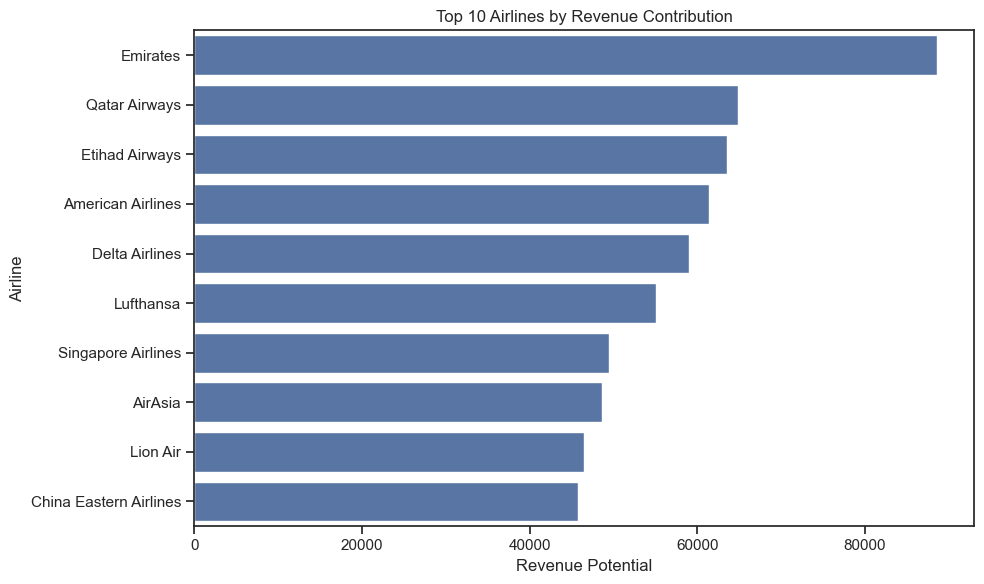

In [77]:
plt.figure(figsize=(10,6))
sns.barplot(
    y=airline_revenue.index, 
    x=airline_revenue.values
)
plt.title('Top 10 Airlines by Revenue Contribution')
plt.xlabel('Revenue Potential')
plt.ylabel('Airline')
plt.tight_layout()
plt.savefig(r"C:\Users\Admin\Documents\boeing-vs-airbus-analysis\visuals\charts\top_airlines_revenue_ccontribution.png", dpi=300)
plt.show()